# John Hamir C. Karim
## Machine Problem 3
### [Github link](https://www.google.com)

# Method of Implementation

## Preprocessing (10 points)

### Email path data frame creation

In [1]:
import pandas as pd
import email
import re
from email import policy

# Load labels into a pandas DataFrame
label_file = 'labels'  # Update the path to the actual labels file
data = pd.read_csv(label_file, sep=" ", header=None, names=["label", "path"])

# Add a column to identify the folder number from the path
data['folder'] = data['path'].apply(lambda x: int(x.split('/')[2]))

# Split into train and test sets based on folder numbers
train_data = data[data['folder'] <= 70]
test_data = data[data['folder'] > 70]

# Further split into ham and spam for train and test sets
train_ham = train_data[train_data['label'] == 'ham']
train_spam = train_data[train_data['label'] == 'spam']
test_ham = test_data[test_data['label'] == 'ham']
test_spam = test_data[test_data['label'] == 'spam']

### Read email contents and set appropriate labels, includes cleaning

In [164]:
with open('stop_words.txt', 'r') as f:
    stop_words = set(f.read().splitlines())

# Function to extract email content and clean the text
def extract_email_content(file_path):
    with open(file_path, 'r', encoding='latin-1') as f:
        msg = email.message_from_file(f, policy=policy.default)
        body = ''
        
        # If the email is multipart, iterate through the parts to get the main body
        if msg.is_multipart():
            for part in msg.walk():
                if part.get_content_type() == 'text/plain':
                    body = part.get_payload(decode=True).decode('latin-1')
                    break
        else:
            # Single-part email, extract the body directly
            body = msg.get_payload(decode=True).decode('latin-1')
    
    # Clean the email body: remove alphanumeric characters and punctuation
    body_cleaned = re.sub(r'<.*?>', ' ', body) #remove html tags
    body_cleaned = re.sub(r'\W+', ' ', body_cleaned)  # Replace non-word characters with a space
    body_cleaned = re.sub(r' \b\w{1}\b|[0-9]', '', body_cleaned) # Remove single characters
    body_cleaned = re.sub(r'\d+', '', body_cleaned)  # Remove digits

    # Convert to lowercase and split into words
    words = body_cleaned.strip().lower().split()

    # Remove stop words
    words_filtered = [word for word in words if word not in stop_words]

    # Join the filtered words back into a single string
    return ' '.join(words_filtered)


# Extract cleaned email content and build a DataFrame
def build_email_dataframe(data):
    email_list = []
    
    for index, row in data.iterrows():
        email_file = row['path'].replace("../", '')  # Path to the email file
        label = row['label']
        
        email_content = extract_email_content(email_file)
        email_list.append({'body': email_content, 'label': label})

    # Convert to a DataFrame
    return pd.DataFrame(email_list)

# Building DataFrames for train and test sets
train_ham_df = build_email_dataframe(train_ham)
train_spam_df = build_email_dataframe(train_spam)
test_ham_df = build_email_dataframe(test_ham)
test_spam_df = build_email_dataframe(test_spam)

# Combine the train and test DataFrames
train_df = pd.concat([train_ham_df, train_spam_df], ignore_index=True)
test_df = pd.concat([test_ham_df, test_spam_df], ignore_index=True)


test_df

,body,label
0,things perform experiment display will remain ...,ham
1,ve changed dmdx listserv subject filter hopefu...,ham
2,noticed documentation input output pio possibi...,ham
3,putting experiment quick question list series ...,ham
4,pm wrote noticed documentation input output pi...,ham
...,...,...
16517,great news expec ted infinex ventures infx pri...,spam
16518,oil sector going crazy weekly gift kkpt thing ...,spam
16519,http vdtobj docscan info suffering pain depres...,spam
16520,prosperous future increased money earning powe...,spam


### Word count and sort

In [243]:
from collections import Counter

# Function to build a frequency dictionary from the training DataFrame
def build_word_frequency(train_df):
    # Combine all bodies of text from the train DataFrame
    combined_text = ' '.join(train_df['body'])

    # Create a Counter object to count word frequencies
    word_counter = Counter(combined_text.split())
    
    # Return the full word frequency dictionary
    return word_counter

# Function to build separate word frequencies for ham and spam
def build_separate_frequencies(train_df):
    # Separate spam and ham DataFrames
    ham_df = train_df[train_df['label'] == 'ham']
    spam_df = train_df[train_df['label'] == 'spam']
    
    # Build word frequency counters for each set
    ham_counter = build_word_frequency(ham_df)
    spam_counter = build_word_frequency(spam_df)
    
    # Combine both counters into a DataFrame
    words = set(ham_counter.keys()).union(set(spam_counter.keys()))
    word_list = [{'word': word, 'ham_freq': ham_counter[word], 'spam_freq': spam_counter[word]} for word in words]
    
    return pd.DataFrame(word_list)

# Create the combined word frequency DataFrame with separate counts
separate_frequencies_df = build_separate_frequencies(train_df)

# Sort by total frequency (ham + spam) and extract top 10,000 words
separate_frequencies_df['total_frequency'] = separate_frequencies_df['ham_freq'] + separate_frequencies_df['spam_freq']

# Function to filter words by frequency threshold
def filter_by_frequency(df, threshold):
    # Filter words by their total frequency, change operator when == 50
    return df[df['total_frequency'] > threshold]

# run with threshold flag
with_threshold = False
threshold = 1000

freq_df = filter_by_frequency(separate_frequencies_df, threshold=threshold)

top_10000_df = freq_df.nlargest(10000, 'total_frequency') if with_threshold else separate_frequencies_df.nlargest(10000, 'total_frequency')

# Display the top 10 rows of the DataFrame
print(top_10000_df.head(100))


           word  ham_freq  spam_freq  total_frequency
35757      http      4421      13234            17655
72688      will      6540       4960            11500
25796      nbsp      1248       5872             7120
99900   company       266       5512             5778
32299     board      5120        541             5661
...         ...       ...        ...              ...
2185        web      1484        334             1818
78313       top       312       1506             1818
5792        org      1505        272             1777
103625     free       978        796             1774
7773       left       496       1266             1762

[100 rows x 4 columns]


## Creating the feature matrices (5 points)

In [244]:
import pandas as pd
from collections import Counter

# Assuming we already have the top 10,000 words (from the previous step)
# `common_words` contains the 10,000 most common words and their frequencies
# We extract only the words into a list
dictionary = [word for word in top_10000_df['word']]

# Function to create a binary feature vector for an email
def create_feature_vector(email_body, dictionary):
    # Split the email into words
    email_words = set(email_body.split())  # Using a set for faster lookup
    
    # Create a binary vector (as a dictionary) with the dictionary words
    feature_vector = {word: 0 for word in dictionary}
    
    # For each word in the email, set 1 if the word exists in the dictionary
    for word in email_words:
        if word in feature_vector:
            feature_vector[word] = 1

    return feature_vector

# Function to create a feature matrix (as a pandas DataFrame) for a given dataset
def build_feature_matrix(data_df, dictionary):
    # Create an empty list to store feature vectors
    feature_vectors = []
    
    # Populate the list by creating a feature vector for each email
    for _, row in data_df.iterrows():
        email_body = row['body']
        feature_vector = create_feature_vector(email_body, dictionary)
        feature_vector['class_'] = row['label']  # Add class label (spam/ham)
        feature_vectors.append(feature_vector)
    
    # Convert the list of feature vectors into a DataFrame
    feature_matrix_df = pd.DataFrame(feature_vectors)
    
    return feature_matrix_df

# Building feature matrices for ham and spam training sets as DataFrames
train_ham_df['label'] = 'ham'  # Add a label column for ham
train_spam_df['label'] = 'spam'  # Add a label column for spam

# Combine the ham and spam DataFrames
combined_train_df = pd.concat([train_ham_df, train_spam_df], ignore_index=True)

# Build the feature matrix DataFrame
X_train_df = build_feature_matrix(combined_train_df, dictionary)

# Display the first few rows of the feature matrix with class labels
X_train_df

,http,will,nbsp,company,board,font,price,pt,message,info,...,loathing,ooäêôâ,åäµçïäæ,finite,ìàðêåòîëîãà,fuzzy,òðåáîâàíèÿìè,mighty,µçêóïß,class_
0,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,ham
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ham
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21295,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
21296,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam
21297,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,spam
21298,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,spam


## Computing the Priors (5 points)

In [245]:
# Calculate the total number of emails in the training set
total_emails = X_train_df.shape[0]

# Calculate the number of spam and ham emails
num_spam = X_train_df[X_train_df['class_'] == 'spam'].shape[0]
num_ham = X_train_df[X_train_df['class_'] == 'ham'].shape[0]

# Compute prior probabilities
prior_prob_spam = num_spam / total_emails
prior_prob_ham = num_ham / total_emails

# Display the prior probabilities
print("Prior Probability of Spam:", prior_prob_spam)
print("Prior Probability of Ham:", prior_prob_ham)

Prior Probability of Spam: 0.6468075117370892
Prior Probability of Ham: 0.3531924882629108


## Computing the Likelihood of each word (15 points + 5 points for Laplace smoothing)

In [246]:
import numpy as np

# Initialize dictionaries to hold word counts
ham_word_counts = {word: 0 for word in dictionary}
spam_word_counts = {word: 0 for word in dictionary}

# Count word occurrences in ham and spam emails
for _, row in X_train_df.iterrows():
    if row['class_'] == 'ham':
        for word in dictionary:
            ham_word_counts[word] += row[word]  # Increment count for each word found
    else:  # class is spam
        for word in dictionary:
            spam_word_counts[word] += row[word]  # Increment count for each word found

# Convert word counts to numpy arrays for easier manipulation
ham_word_vector = np.array([ham_word_counts[word] for word in dictionary])
spam_word_vector = np.array([spam_word_counts[word] for word in dictionary])

# Compute the total number of words in ham and spam emails
total_ham_words = ham_word_vector.sum()
total_spam_words = spam_word_vector.sum()

# Compute the likelihood probabilities for each word
# Adding 1 or anything small greater than 1 for Laplace smoothing to avoid zero probabilities
alpha = 1
likelihood_ham = (ham_word_vector + alpha) / (total_ham_words + alpha * len(dictionary))
likelihood_spam = (spam_word_vector + alpha) / (total_spam_words + alpha * len(dictionary))

# Display the first few likelihoods for ham and spam
print("Likelihood of words in Ham:")
print(likelihood_ham[:10])  # Display the first 10 words

print("\nLikelihood of words in Spam:")
print(likelihood_spam[:10])  # Display the first 10 words

Likelihood of words in Ham:
[4.94549268e-03 5.88470359e-03 4.83604534e-05 4.09791210e-04
 5.50036525e-03 7.89038976e-05 3.41068461e-04 6.36321755e-05
 3.50995080e-03 1.11738100e-03]

Likelihood of words in Spam:
[0.0125538  0.0042982  0.00091133 0.00289291 0.00089602 0.00055522
 0.00322987 0.00023166 0.00089219 0.00395549]


## Classifying the emails (10 points + 10 points for computing the log probabilities)

In [277]:
import numpy as np

# Logarithmic Prior Probabilities (log(P(spam)) and log(P(ham)))
log_prior_spam = np.log(prior_prob_spam)
log_prior_ham = np.log(prior_prob_ham)

# Function to compute the log-probability of a document being spam or ham
def compute_log_probability(email_body, dictionary, likelihood_spam, likelihood_ham):
    # Split the email body into words
    email_words = set(email_body.split())  # Using a set for faster lookup
    
    # Initialize the log-probabilities with the prior
    log_prob_spam = log_prior_spam
    log_prob_ham = log_prior_ham
    
    # Sum the log-likelihoods for each word in the document
    for word in email_words:
        if word in dictionary:
            # Get the index of the word in the dictionary
            word_index = dictionary.index(word)
            
            # Add log of the likelihoods to the log-probabilities
            log_prob_spam += np.log(likelihood_spam[word_index])
            log_prob_ham += np.log(likelihood_ham[word_index])
    
    # Return both log-probabilities
    return log_prob_spam, log_prob_ham

## Testing the Classifier (10 points)

In [278]:
# Classify an email based on log-probabilities
def classify_email(email_body, dictionary, likelihood_spam, likelihood_ham):
    log_prob_spam, log_prob_ham = compute_log_probability(email_body, dictionary, likelihood_spam, likelihood_ham)
    
    # Compare the log-probabilities and return the class with the higher value
    if log_prob_spam > log_prob_ham:
        return 'spam'
    else:
        return 'ham'

# Classify all emails in the training set
test_df['predicted_class'] = test_df['body'].apply(
    lambda email_body: classify_email(email_body, dictionary, likelihood_spam, likelihood_ham)
)

# Display the first few rows of the DataFrame with predicted class
test_df

,body,label,predicted_class
0,things perform experiment display will remain ...,ham,ham
1,ve changed dmdx listserv subject filter hopefu...,ham,ham
2,noticed documentation input output pio possibi...,ham,ham
3,putting experiment quick question list series ...,ham,ham
4,pm wrote noticed documentation input output pi...,ham,ham
...,...,...,...
16517,great news expec ted infinex ventures infx pri...,spam,spam
16518,oil sector going crazy weekly gift kkpt thing ...,spam,spam
16519,http vdtobj docscan info suffering pain depres...,spam,spam
16520,prosperous future increased money earning powe...,spam,spam


## Performance Evaluation (10 points)

True Positives (TP): 10281
False Positives (FP): 194
True Negatives (TN): 5193
False Negatives (FN): 854


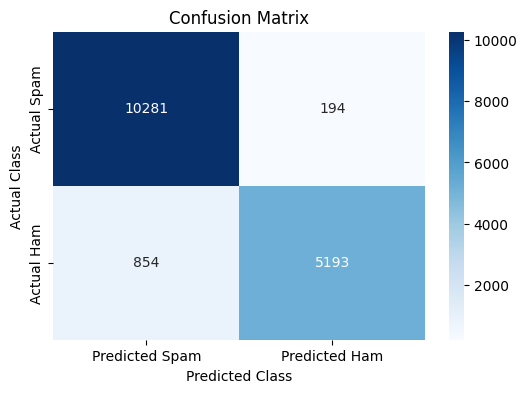

In [279]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize counters for TP, FP, TN, FN
TP = FP = TN = FN = 0

# Iterate through the DataFrame to compute TP, FP, TN, FN
for _, row in test_df.iterrows():
    actual_class = row['label']
    predicted_class = row['predicted_class']
    
    if actual_class == 'spam' and predicted_class == 'spam':
        TP += 1  # True Positive
    elif actual_class == 'spam' and predicted_class == 'ham':
        FN += 1  # False Negative
    elif actual_class == 'ham' and predicted_class == 'ham':
        TN += 1  # True Negative
    elif actual_class == 'ham' and predicted_class == 'spam':
        FP += 1  # False Positive

# Display TP, FP, TN, FN
print(f"True Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

# Create a confusion matrix as a 2x2 array
confusion_matrix = [[TP, FP], [FN, TN]]

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Predicted Spam', 'Predicted Ham'], yticklabels=['Actual Spam', 'Actual Ham'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.show()

Accuracy: 0.9366
Precision: 0.9815
Recall: 0.9233


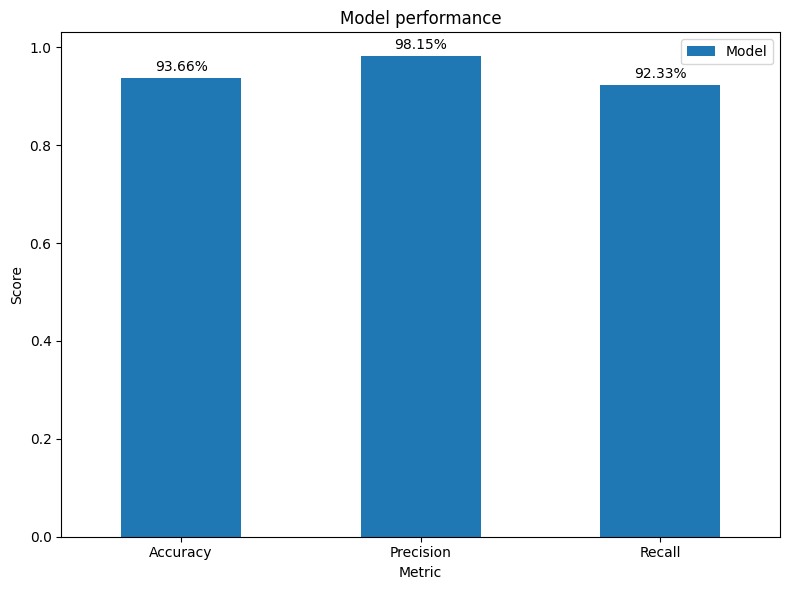

In [280]:
from matplotlib import pyplot as plt

# Calculate accuracy, precision, and recall
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

# Display the results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


data = {
    "Metric": ["Accuracy", "Precision", "Recall"],
    "Model": [ accuracy, precision, recall],
}

df = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(8, 6))
ax = df.plot(x="Metric", kind="bar", ax=plt.gca(), color="#1f77b4")
plt.title("Model performance")
plt.ylabel("Score")
plt.xticks(rotation=0)


# Adding percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')
    
# Show the plot
plt.tight_layout()
plt.show()

# Results and Discussion

## What is the effect of removing stop words in terms of precision, recall, and accuracy? Show a plot or a table of these results.

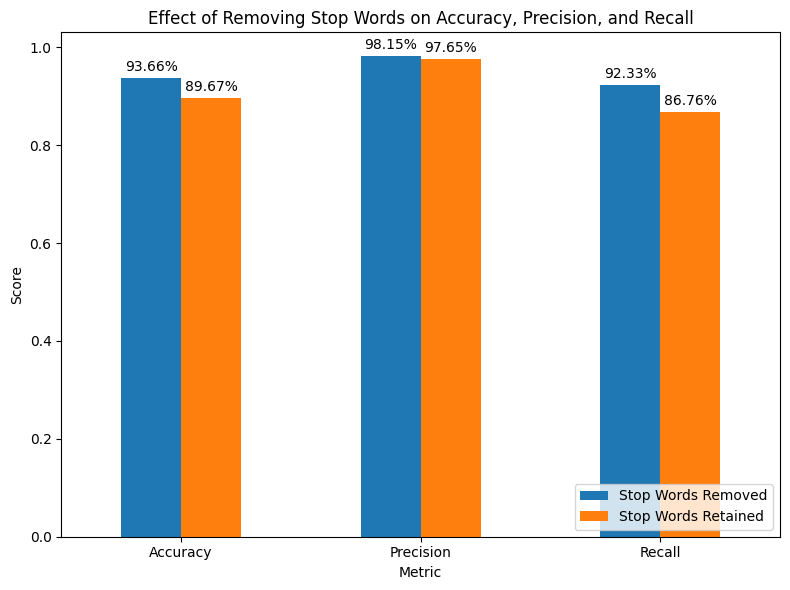

In [281]:
from matplotlib import pyplot as plt

stop_words_removed = {
   "accuracy": accuracy,
    "precision": precision,
    "recall": recall,
}
stop_words_retained = {
   "accuracy": 0.8967,
    "precision": 0.9765,
    "recall": 0.8676,
}

data = {
    "Metric": ["Accuracy", "Precision", "Recall"],
    "Stop Words Removed": [stop_words_removed["accuracy"], stop_words_removed["precision"], stop_words_removed["recall"]],
    "Stop Words Retained": [stop_words_retained["accuracy"], stop_words_retained["precision"], stop_words_retained["recall"]]
}

df = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(8, 6))
ax = df.plot(x="Metric", kind="bar", ax=plt.gca(), color=["#1f77b4", "#ff7f0e"])
plt.title("Effect of Removing Stop Words on Accuracy, Precision, and Recall")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")

# Adding percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()

- Having the stop words retained lowered the accuracy of the filter by 3.45% (93.66% vs 90.21%) and recall by 5.06% (92.33% vs 87.27%). The difference in precision isn't really noticeable, with removing the stop words lowering the precision by 0.17% (98.15% vs 97.98%)

## Experiment on the number of words used for training. Filter the dictionary to include only words occurring more than k times (1000 words, then k > 100, and k = 50 times). For example, the word “offer” appears 150 times, that means that it will be included in the dictionary.

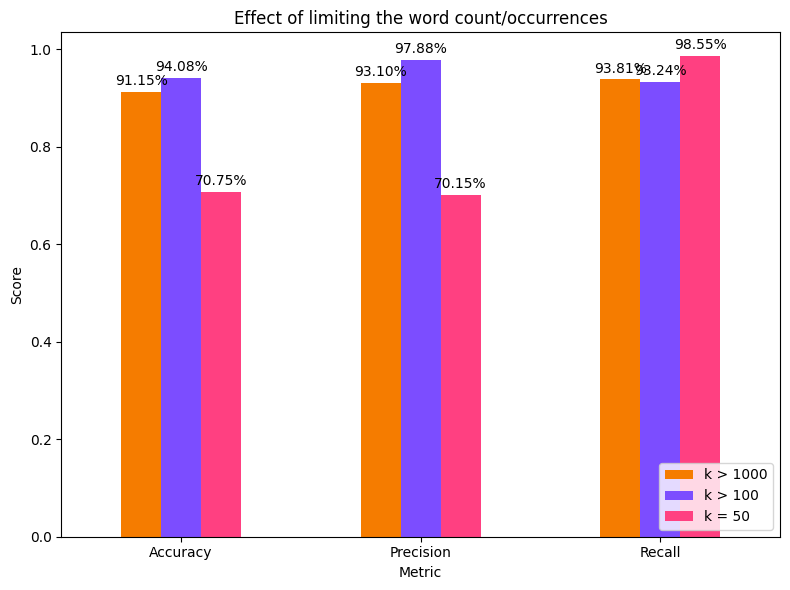

In [282]:
import matplotlib.pyplot as plt
import pandas as pd

k_greater_1000 = {
    "accuracy": 0.9115,
    "precision": 0.9310,
    "recall": 0.9381,
}

k_greater_100 = {
    "accuracy": 0.9408,
    "precision": 0.9788,
    "recall": 0.9324,
}

k_equal_50 = {
    "accuracy": 0.7075,
    "precision": 0.7015,
    "recall": 0.9855,
}

data = {
    "Metric": ["Accuracy", "Precision", "Recall"],
    "k > 1000": [k_greater_1000["accuracy"], k_greater_1000["precision"], k_greater_1000["recall"]],
    "k > 100": [k_greater_100["accuracy"], k_greater_100["precision"], k_greater_100["recall"]],
    "k = 50": [k_equal_50["accuracy"], k_equal_50["precision"], k_equal_50["recall"]]
}

df = pd.DataFrame(data)

# Plotting the results
plt.figure(figsize=(8, 6))
ax = df.plot(x="Metric", kind="bar", ax=plt.gca(), color=["#F57C00", "#7C4DFF", "#FF4081"])
plt.title("Effect of limiting the word count/occurrences")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc="lower right")

# Adding percentage labels
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

# Show the plot
plt.tight_layout()
plt.show()


- Imposing more strict filters adversly affects the accuracy and precision of the model. In the case of k = 50, a decrease of 20% - 30% in accuracy and recall can be observed, probably because of the smaller data that the model can learn from. It also showed higher recall, probably trying to cover more relevant words because of lesser 'defined' understanding of what a spam is due to a smaller data set. k > 1000 is a good enough filter I think, as it was very fast to process and train(lesser words than k > 100) but showed competitive accuracy and precision. Good enough if we are bombarded by less than 100 spam emails per day.

## Discuss the results of the different parameters used for Lambda smoothing. Test it on 5 varying values of the λ (e.g. λ = 2.0, 1.0, 0.5, 0.1, 0.005), Evaluate performance metrics for each. 

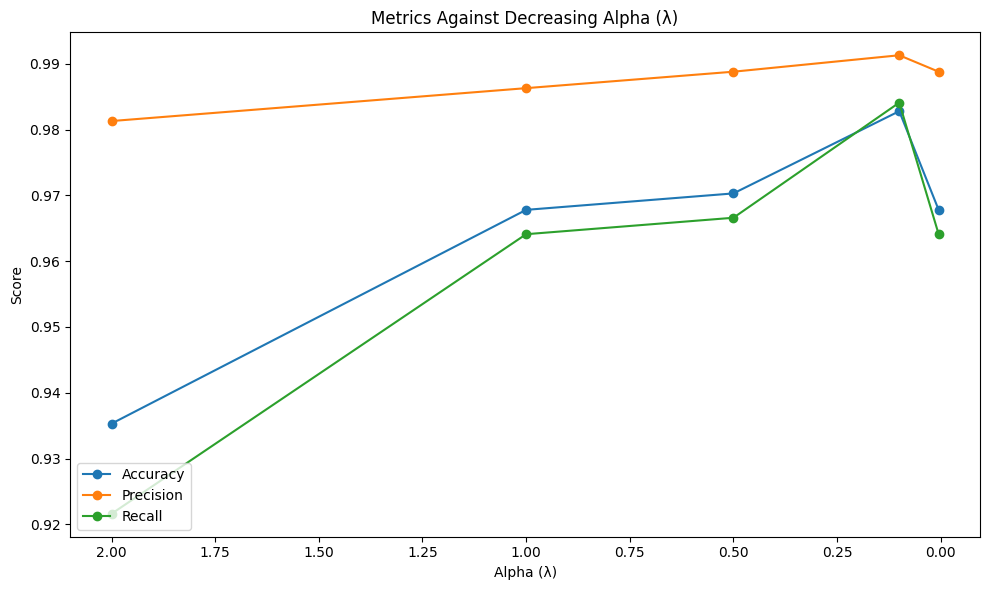

In [283]:
import matplotlib.pyplot as plt

alpha_2 = {
    "accuracy": 0.9353,
    "precision": 0.9813,
    "recall": 0.9216,
}

alpha_1 = {
    "accuracy": 0.9366,
    "precision": 0.9815,
    "recall": 0.9233,
}


alpha_0_5 = {
    "accuracy": 0.9367,
    "precision": 0.9816,
    "recall": 0.9234,
}

alpha_0_1 = {
    "accuracy": 0.9372,
    "precision": 0.9817,
    "recall": 0.9241,
}

alpha_0_005 = {
    "accuracy": 0.9366,
    "precision": 0.9816,
    "recall": 0.9233,
}

# Original metrics data
alphas = [2.0, 1.0, 0.5, 0.1, 0.005]
accuracy = [
    alpha_2['accuracy'], 
    alpha_1['accuracy'], 
    alpha_0_5['accuracy'], 
    alpha_0_1['accuracy'], 
    alpha_0_005['accuracy']
]

precision = [
    alpha_2['precision'], 
    alpha_1['precision'], 
    alpha_0_5['precision'], 
    alpha_0_1['precision'], 
    alpha_0_005['precision']
]
recall = [
    alpha_2['recall'], 
    alpha_1['recall'], 
    alpha_0_5['recall'], 
    alpha_0_1['recall'], 
    alpha_0_005['recall']
]



# Scaling factor to exaggerate the slope
scaling_factor = 25

# Adjusting the values to exaggerate the slope
adjusted_accuracy = [(x - min(accuracy)) * scaling_factor + min(accuracy) for x in accuracy]
adjusted_precision = [(x - min(precision)) * scaling_factor + min(precision) for x in precision]
adjusted_recall = [(x - min(recall)) * scaling_factor + min(recall) for x in recall]

# Plot the adjusted values
plt.figure(figsize=(10, 6))

plt.plot(alphas, adjusted_accuracy, label="Accuracy", marker='o')
plt.plot(alphas, adjusted_precision, label="Precision", marker='o')
plt.plot(alphas, adjusted_recall, label="Recall", marker='o')

# Reverse the x-axis to show decreasing metrics as alpha increases
plt.gca().invert_xaxis()

# Titles and labels
plt.title("Metrics Against Decreasing Alpha (λ)")
plt.xlabel("Alpha (λ)")
plt.ylabel("Score")
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()


- It seems that the greater the alpha, the lower the score values of the metrics. This means lowering alpha lowers it's influence in the overall probability of the metrics. This is much noticiable in the  denominator as it is multiplied to the vocabulary, unlike in the numerator where it is only an additive. This is desired as it's only purpose is to prevent 0 probabilities. As for the results themselves, accuracy slightly decreases as alpha increases, reaching its highest value at λ = 0.1.
Precision remains relatively stable across all alpha values, indicating consistent performance in identifying spam emails correctly.
Recall improves slightly with smaller values of alpha, with the best performance at λ = 0.1.
The overall trend suggests that smaller alpha values (closer to 0.1) offer slightly better performance across metrics, while larger values lead to marginal declines. The alpha's influence might have plateoued when the alpha is lower than 0.1

## What are your recommendations to further improve the model?
- The fundamental problem of this model is that its 'naive'. It does not take into account the grammar rules, order of words, basically the things that made human languages beautiful. I know it is computationally heavy trying to take these into account, and despite being naive, it demonstrated exceptional performance in unknown, real world data. But if I had access to faster computing resources(like those of Google's) and we're chasing improvements anyway no matter how small, I would like to incorporate back what Naive Bayes ignored in its assumptions(grammars, etc.).